# Complaints Analysis

## Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import seaborn as sns
import spacy
import string
import pprint
from wordcloud import WordCloud

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
PARENT_DIR = os.getcwd().rsplit("\\", maxsplit=1)[0]
DATASET_DIR = os.path.join(PARENT_DIR, "Datasets")

## Utilities

In [4]:
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.alpha"] = "0.2"
plt.rcParams["grid.linestyle"] = "-."

In [5]:
def get_random_row(df : pd.DataFrame):
    rand_row = df.sample().iloc[0]
    print("ODINO:", rand_row["ODINO"])
    pprint.pprint(f"FAILDATE: {rand_row['FAILDATE']}")
    pprint.pprint(f"CITY: {rand_row['CITY']}")
    pprint.pprint(f"STATE: {rand_row['STATE']}")
    pprint.pprint(f"COMPDESC: {rand_row['COMPDESC']}")
    pprint.pprint(f"CDESCR: {rand_row['CDESCR']}")

In [6]:
def find_columns_defining_uniqueness(df : pd.DataFrame, duplicates_allowed=0):
    '''
        Find columns that defines a dataframe's uniqueness
        based on duplicate threshold requirements.

        df : DataFrame
        duplicates_allowed : how many ODINOs we want in our final dataset
    '''
    prev_length = -1
    columns_defining_uniqueness = ["ODINO"]
    while len(df) > 0 and len(df["ODINO"].unique()) > duplicates_allowed:
        # Find column with max unique counts that's not already selected
        unique_counts_per_odino = df.groupby("ODINO").nunique().sum(axis=0).sort_values(ascending=False)
        max_unique_count = -1
        max_unique_count_index = -1
        for i, column in enumerate(unique_counts_per_odino.index):
            if column in columns_defining_uniqueness:
                continue
            else:
                max_unique_count = unique_counts_per_odino.loc[column]
                max_unique_count_index = i
                break
        
        if max_unique_count == -1:
            break

        if max_unique_count > len(df["ODINO"].unique()):
            columns_defining_uniqueness.append(unique_counts_per_odino.index[max_unique_count_index])
            df = df.loc[df.duplicated(subset=columns_defining_uniqueness, keep=False)]
        else:
            # No more column additions brings value
            break
    return columns_defining_uniqueness



In [7]:
def plot_distrib(df: pd.DataFrame, column_name: str,
                bins=None):
    '''
      Plot distribution on histogram
      :param df: polars dataframe
      :param column_name: column name to plot distribution of
      :param bins: number of bins to use
    '''
    fig, ax = plt.subplots()
    if bins is None:
      ## Assume values ar from range 1 to num_unique if bins are not specified
      num_unique = len(df[column_name].unique())
      bins = [i+1 for i in range(num_unique+1)]

    _, _, patches = ax.hist(x=df[column_name], align='left',
                bins=bins,
                rwidth=0.8)
    _ = ax.set_title(f"Distribution of {column_name}")
    _ = ax.set_ylabel("Number of Reviews")
    _ = ax.set_xlabel(column_name)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_locator(ticker.FixedLocator(bins[:-1]))
    totals = sum(ax.containers[0].datavalues)
    max_bar_height = max([patch.get_height() for patch in patches])
    slight_padding = max_bar_height * 0.01
    for i, patch in enumerate(patches):
      bar_height = patch.get_height()
      proportion_of_max_height = bar_height / max_bar_height
      if proportion_of_max_height < 0.05:
        # Place the label above the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height + slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='bottom', color='black')
      else:
        # Place the label inside the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height - slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='top', color='white')
    # ax.bar_label(ax.containers[0], color="white",
    #              padding=-15,
    #              labels=[f"{x/totals * 100:.2f}%"
    #                      if not np.isclose(x, 0) else ""
    #                      for x in ax.containers[0].datavalues])
    return fig, ax

def generate_word_frequencies_from_column(df, column):
    # Find all words in the column
    df = df.drop_duplicates(subset=[column])
    all_words = df[column].str.findall("\\b\\w\\w+\\b").explode(column)
    all_words = all_words.str.lower()

    # Get word counts. We have column in column string for word and column 'count' for frequency 
    word_frequencies = all_words.value_counts().reset_index()

    # Remove stopwords and words which do not contain letters (ex. 2016, 2017, 2018)
    uninterested_words_filter = (
        (word_frequencies[column].isin(nlp.Defaults.stop_words)) |
        ~(word_frequencies[column].str.contains("[a-zA-Z]"))
    )
    word_frequencies = word_frequencies.loc[
        ~uninterested_words_filter
    ]
    escaped_puncs = re.escape(string.punctuation)
    # There should be no punctuations present in any of the words
    assert len(
        word_frequencies[word_frequencies[column].str.contains('|'.join(escaped_puncs.split()))]
    ) == 0, \
    "There should be no punctuations in the analyzed words"
    return word_frequencies.set_index(column)


## Load Complaints Dataset

In [8]:
df_complaints = pd.read_csv(f"{DATASET_DIR}/COMPLAINTS_RECEIVED_2025-2025.txt", sep='\t', header=None, index_col=0)
df_complaints.columns = ['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH', 'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE', 'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE', 'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
              'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE', 'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE', 'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY', 'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']

C:\Users\harri\AppData\Local\Temp\ipykernel_46416\1253059527.py:1: DtypeWarning: Columns (29,32,35,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_complaints = pd.read_csv(f"{DATASET_DIR}/COMPLAINTS_RECEIVED_2025-2025.txt", sep='\t', header=None, index_col=0)


## Preprocessing

In [9]:
# Lowercase all strings for analysis
for column in df_complaints.columns:
    if column in ["CDESCR"]:
        df_complaints[column] = df_complaints[column].str.lower()

# Lowercase all strings for analysis
for column in df_complaints.columns:
    if df_complaints[column].dtype == object:
        df_complaints[column] = df_complaints[column].fillna("").str.replace("\s+", " ", regex=True)

df_complaints["MMYTXT"] = (
    df_complaints["MAKETXT"] + " " + df_complaints["MODELTXT"] + " " + df_complaints["YEARTXT"].astype(str)
)

## Descriptive Summary

In [10]:
df_complaints.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY',
       'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN',
       'MEDICAL_ATTN', 'VEHICLES_TOWED_YN', 'MMYTXT'],
      dtype='object')

In [11]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17239 entries, 2051723 to 2068962
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ODINO              17239 non-null  int64  
 1   MFR_NAME           17239 non-null  object 
 2   MAKETXT            17239 non-null  object 
 3   MODELTXT           17239 non-null  object 
 4   YEARTXT            17239 non-null  int64  
 5   CRASH              17239 non-null  object 
 6   FAILDATE           17239 non-null  int64  
 7   FIRE               17239 non-null  object 
 8   INJURED            17239 non-null  int64  
 9   DEATHS             17239 non-null  int64  
 10  COMPDESC           17239 non-null  object 
 11  CITY               17239 non-null  object 
 12  STATE              17239 non-null  object 
 13  VIN                17239 non-null  object 
 14  DATEA              17239 non-null  int64  
 15  LDATE              17239 non-null  int64  
 16  MILES              

### CDESCR String Length

In [13]:
df_string_length = df_complaints["CDESCR"].drop_duplicates().str.len()

In [14]:
df_string_length.describe()

count    11608.000000
mean       615.631116
std        452.685924
min          0.000000
25%        284.000000
50%        522.000000
75%        807.000000
max       2048.000000
Name: CDESCR, dtype: float64

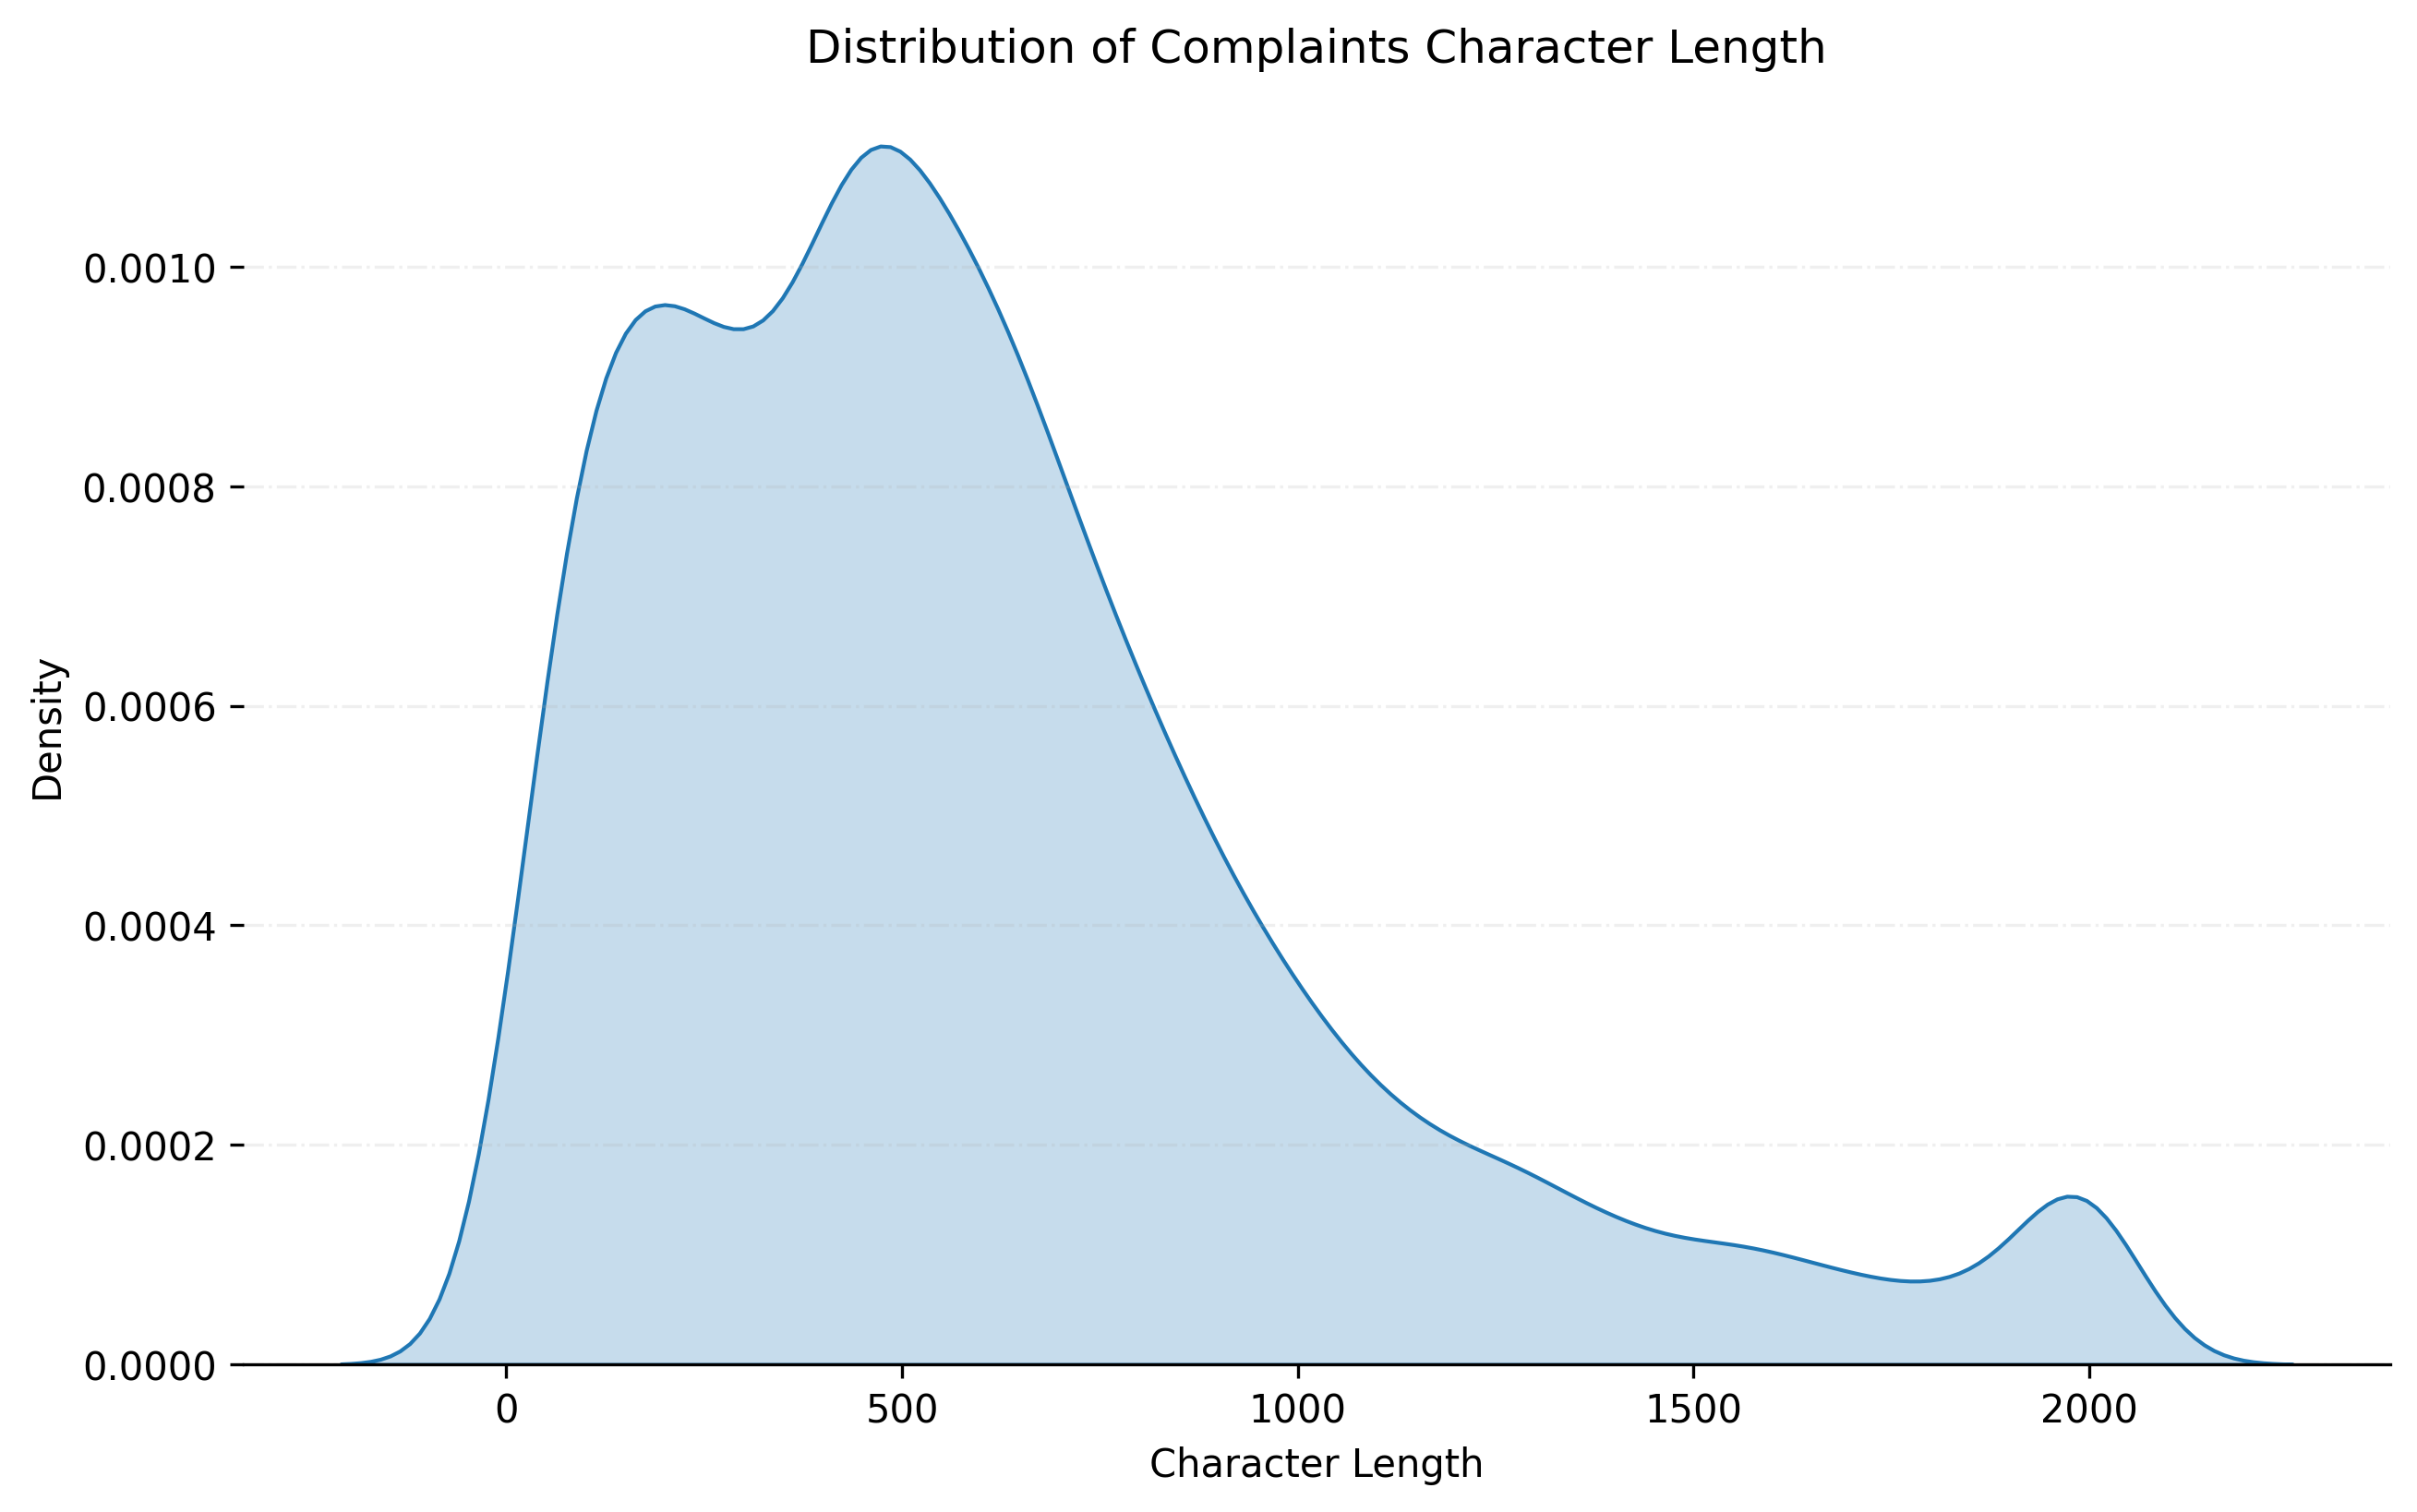

In [15]:
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length, fill=True)
plt.title("Distribution of Complaints Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.show()


Why are complaints so long

#### General Distribution of Make

In [16]:
df_complaints["MAKETXT"].unique()

array(['FORD', 'JEEP', 'TOYOTA', 'BUICK', 'HONDA', 'TESLA', 'VOLKSWAGEN',
       'GMC', 'DODGE', 'HYUNDAI', 'CFMOTO', 'CHRYSLER', 'KIA', 'TBD',
       'VOLVO', 'MERCEDES-BENZ', 'CHEVROLET', 'BMW', 'RAM', 'MAZDA',
       'UNKNOWN', 'ACURA', 'LINCOLN', 'SUBARU', 'CADILLAC',
       'GRAND DESIGN', 'NISSAN', 'GOODYEAR', 'HANKOOK', 'LEXUS', 'HUMMER',
       'EVENFLO', 'GENESIS', 'HARLEY-DAVIDSON', 'JAGUAR', 'MERCURY',
       'PETERBILT', 'TAXA', 'NUNA', 'LAND ROVER', 'KEYSTONE',
       'MERCEDES BENZ', 'FISKER', 'FIRESTONE', 'INFINITI', 'MITSUBISHI',
       'CHICCO', 'POLESTAR', 'FREIGHTLINER', 'MEVOTECH', 'AUDI',
       'BLUE OX', 'CONTINENTAL TIRE', 'FOREST RIVER', 'GENESIS SUPREME',
       'FIAT', 'MINI', 'PONTIAC', 'MAXI-COSI', 'JAYCO', 'PORSCHE',
       'RIVIAN', 'POLARIS', 'LUCID', 'ENEL X', 'CONTINENTAL',
       'THOR MOTOR COACH', 'LANCE CAMPER', 'ASTON MARTIN', 'VINFAST',
       'COOPER', 'KARAVAN', 'COSCO', 'SATURN', 'ALFA ROMEO',
       'READING TRUCK BODY', 'NEWMAR', 'FLEETWOOD'

In [18]:
maketxt_value_counts = df_complaints.groupby("MAKETXT").nunique("CDESCR")["CDESCR"].sort_values(ascending=False)[:50]

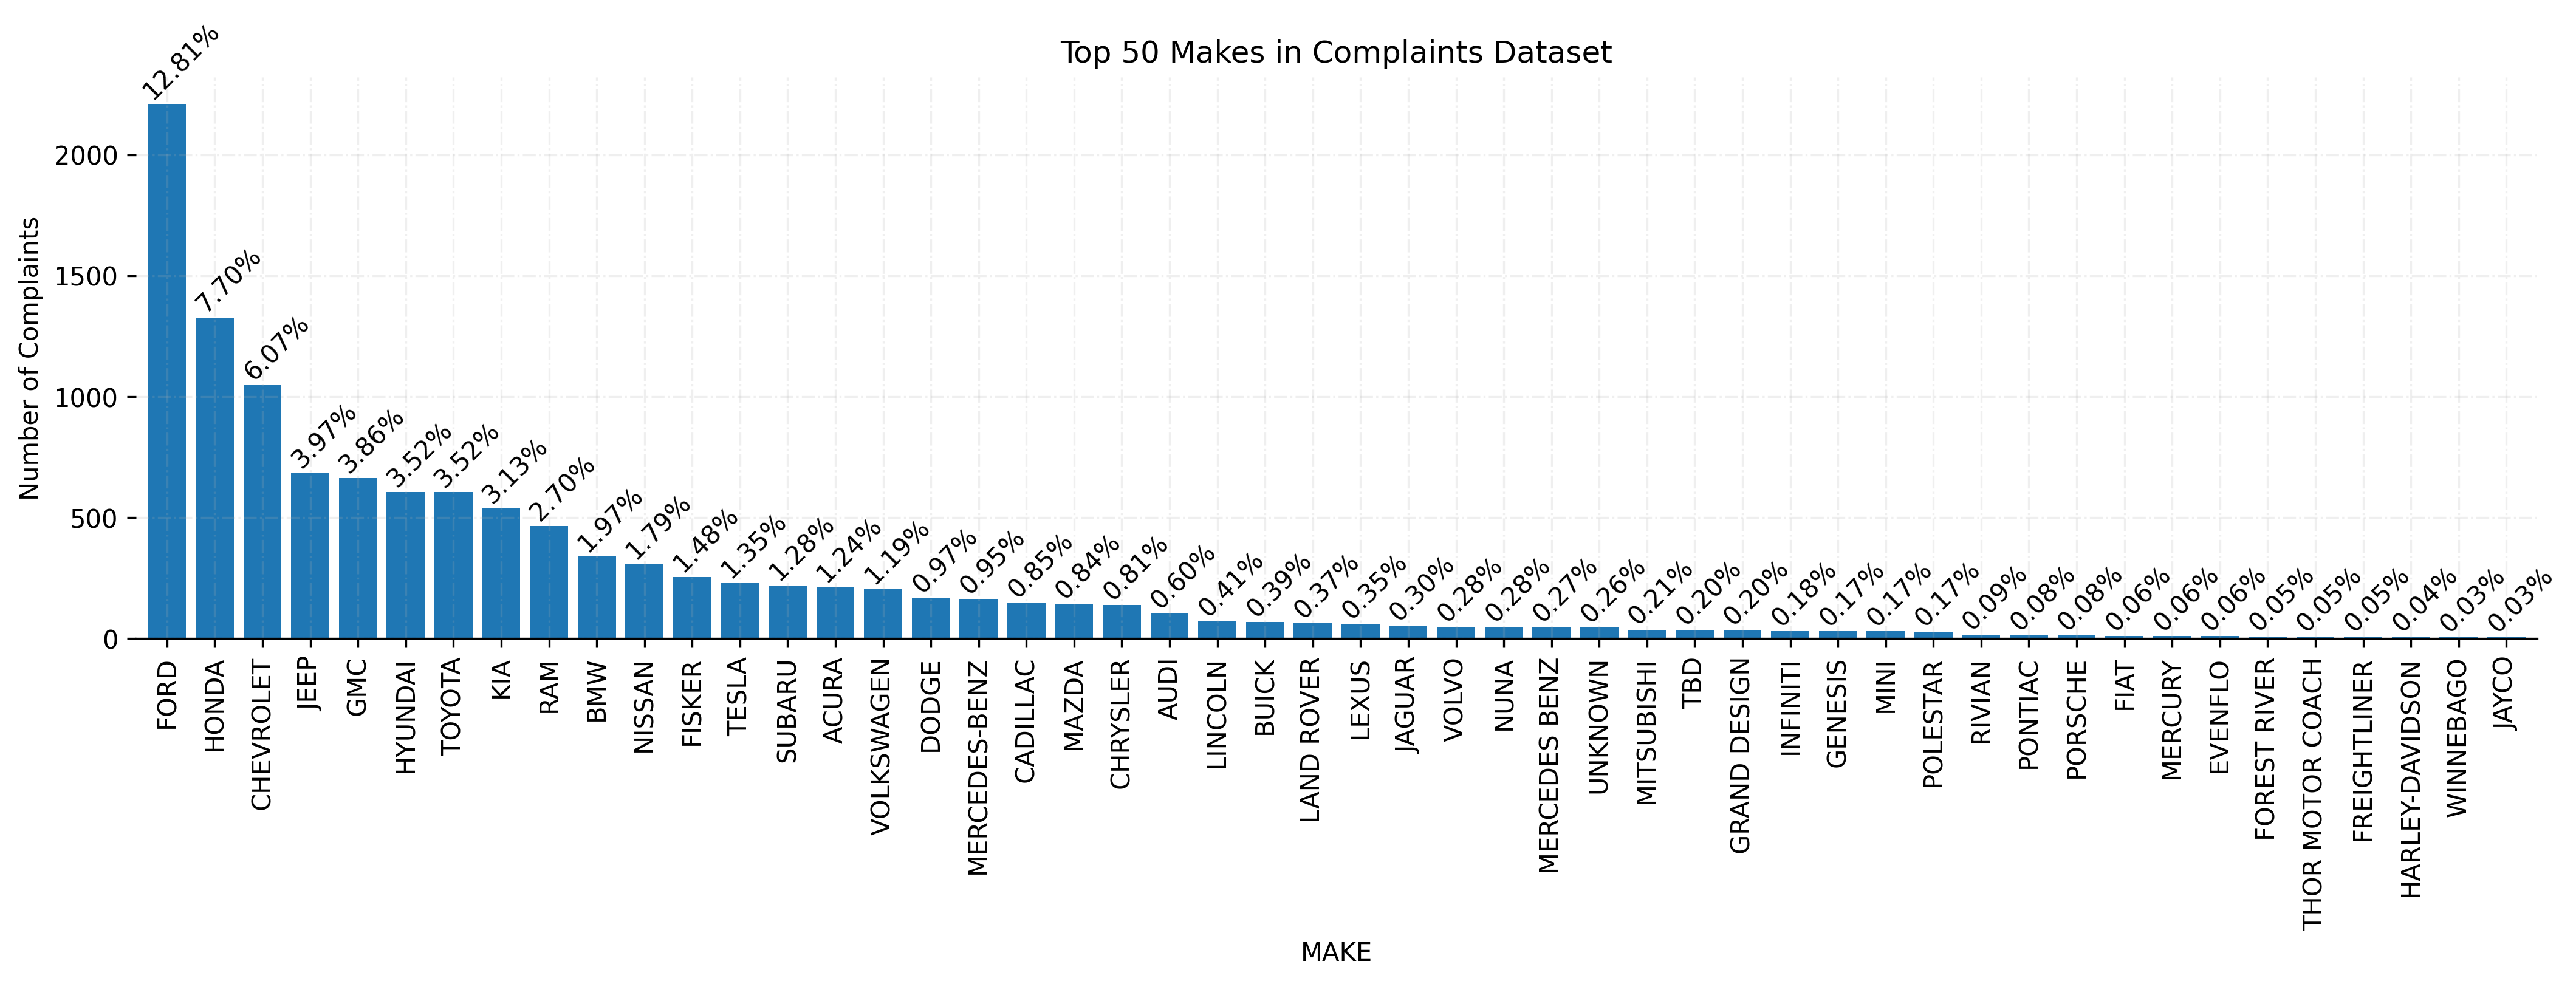

In [19]:
# Plot MAKETXT value counts with percentage text hovering over bar chart
plt.figure(figsize=(17, 4), dpi=300)
maketxt_value_counts.plot(kind='bar', width=0.8)
for i, count in enumerate(maketxt_value_counts):
    plt.text(i + 0.3, count, f"{count / len(df_complaints) * 100:.2f}%", ha='center', va='bottom', rotation=45)
plt.title('Top 50 Makes in Complaints Dataset')
plt.xlabel('MAKE')
plt.ylabel('Number of Complaints')
plt.show()

### CMPL_TYPE 

In [20]:
df_complaints["CMPL_TYPE"].unique()

array(['IVOQ', 'EVOQ'], dtype=object)

In [21]:
complaints_value_counts = df_complaints.drop_duplicates("CDESCR")["CMPL_TYPE"].value_counts()

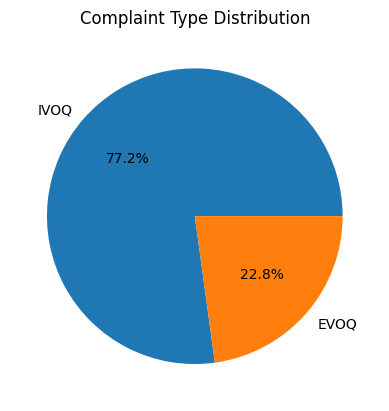

In [22]:
plt.figure(dpi=100)
_ = plt.pie(
    complaints_value_counts, labels=complaints_value_counts.index, autopct='%1.1f%%'
)
_ = plt.title("Complaint Type Distribution")

### Complaints Wordmap

In [23]:
complaints_word_freq = generate_word_frequencies_from_column(df_complaints, "CDESCR")


In [24]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(complaints_word_freq.to_dict()["count"])

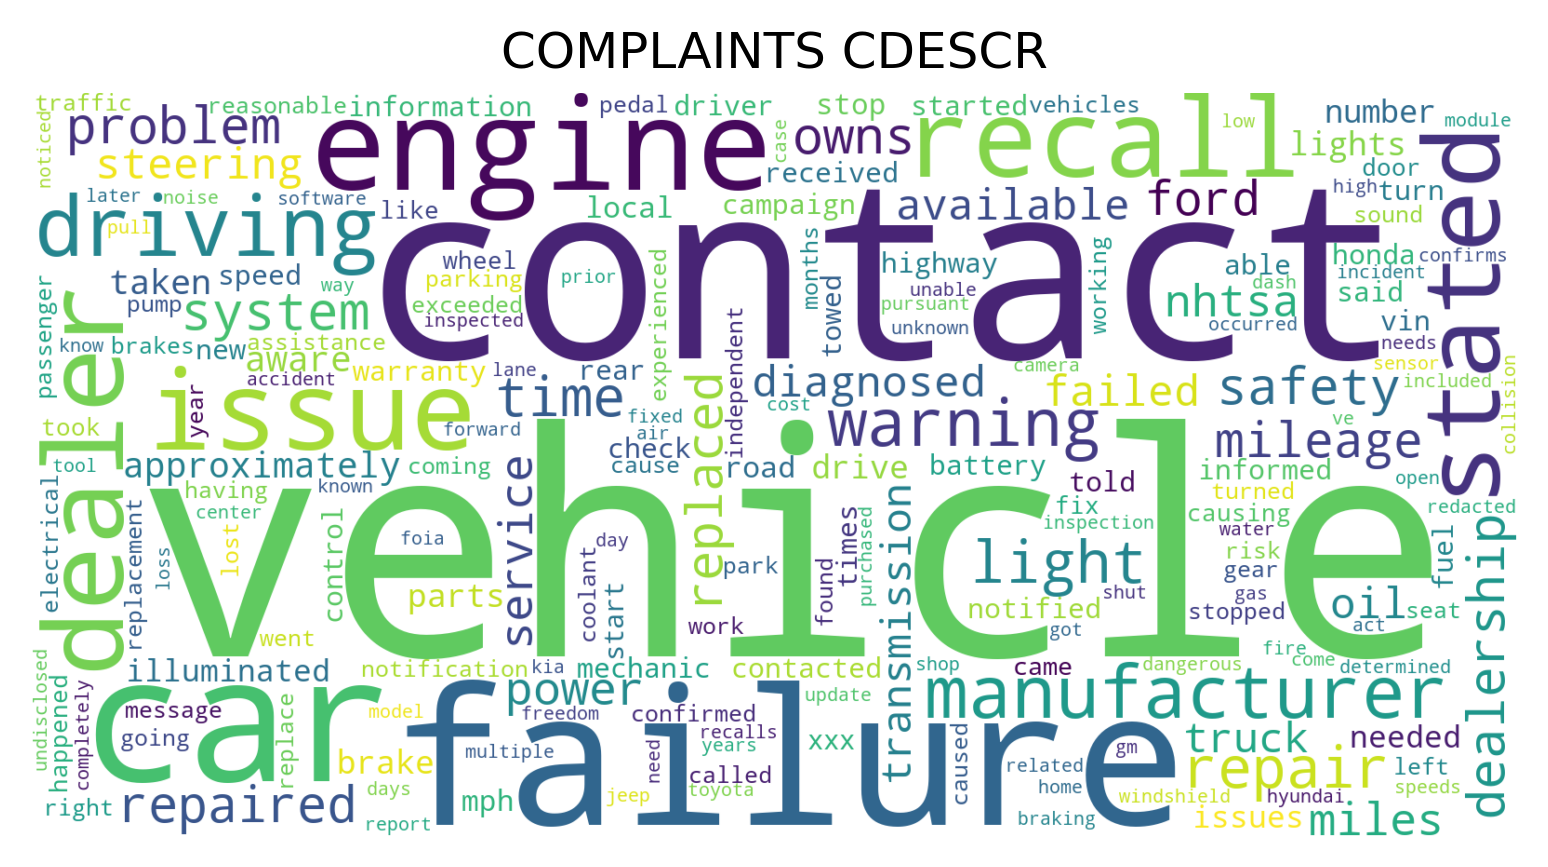

In [25]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPLAINTS CDESCR')

In [28]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df_complaints["CDESCR"].drop_duplicates().str.cat(sep=" "))

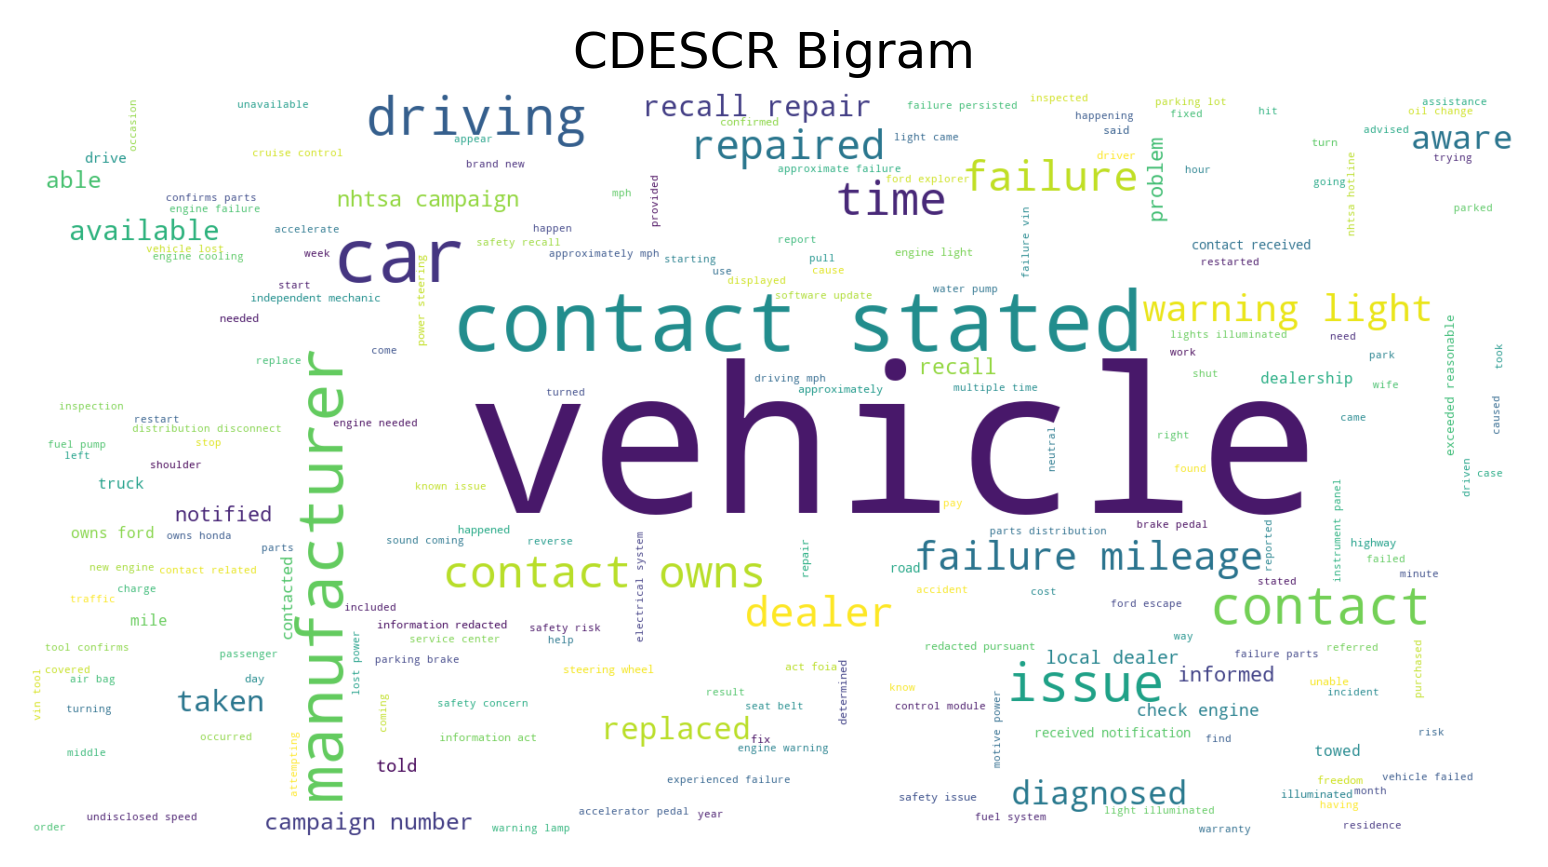

In [29]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('CDESCR Bigram')

In [30]:
get_random_row(df_complaints)   

ODINO: 11637343
'FAILDATE: 20241010'
'CITY: Merritt Island'
'STATE: FL'
'COMPDESC: FUEL/PROPULSION SYSTEM'
('CDESCR: gas tank does not fill properly. gas back feeds up the tube and all '
 'over the car. to fill gas tank it takes about 30min pumping a few cents at a '
 'time. ')


### COMPNAME Distribution

Name of component with defect

In [31]:
compname_word_freq = generate_word_frequencies_from_column(df_complaints, "COMPDESC")

In [32]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(compname_word_freq.to_dict()["count"])

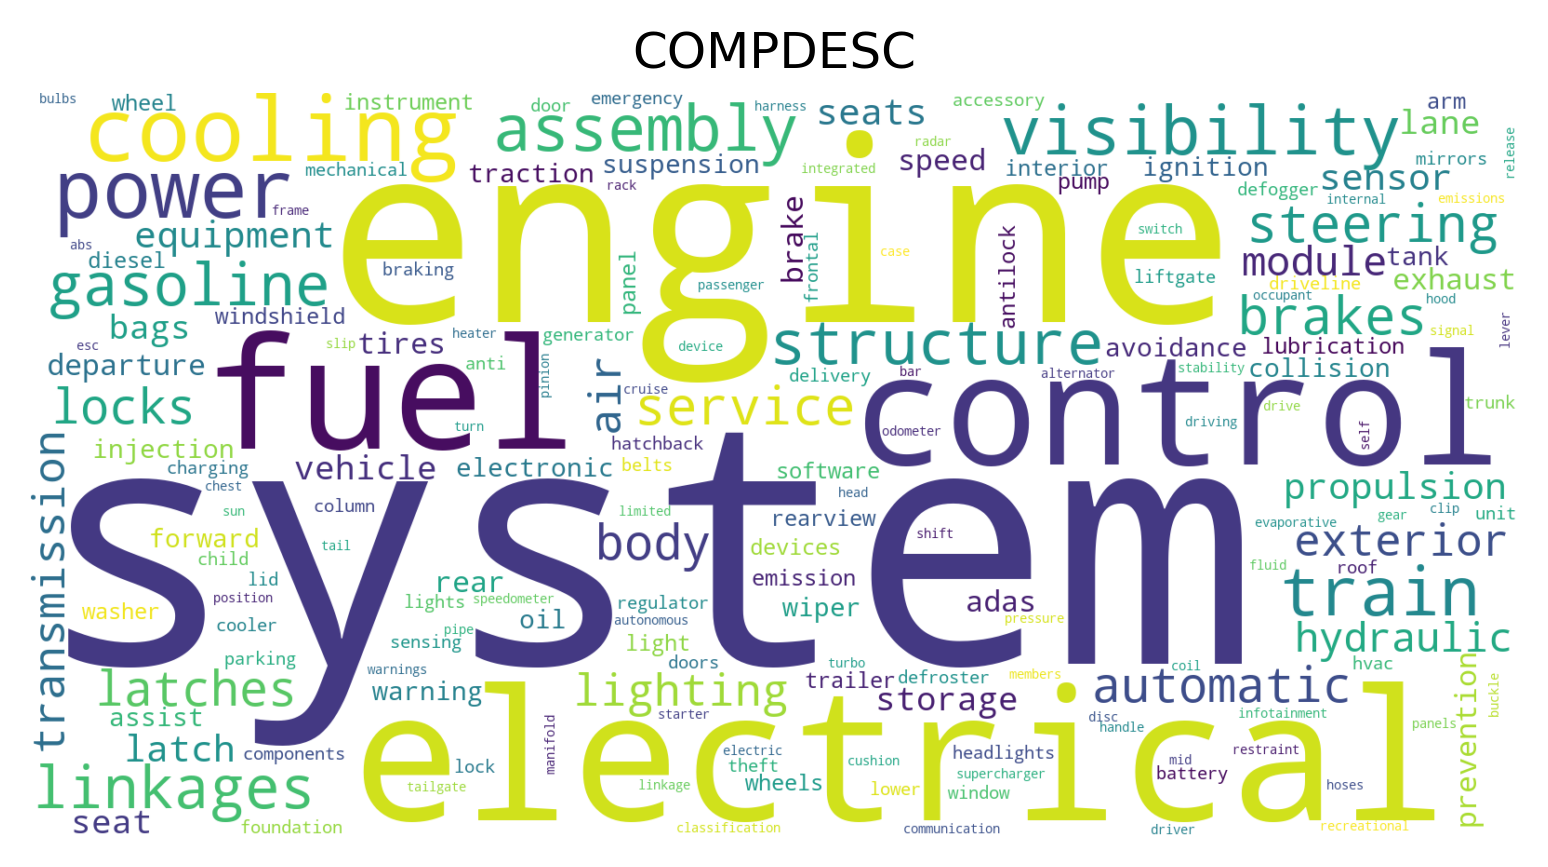

In [33]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPDESC')

In [34]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df_complaints["COMPDESC"].drop_duplicates().str.cat(sep=" "))

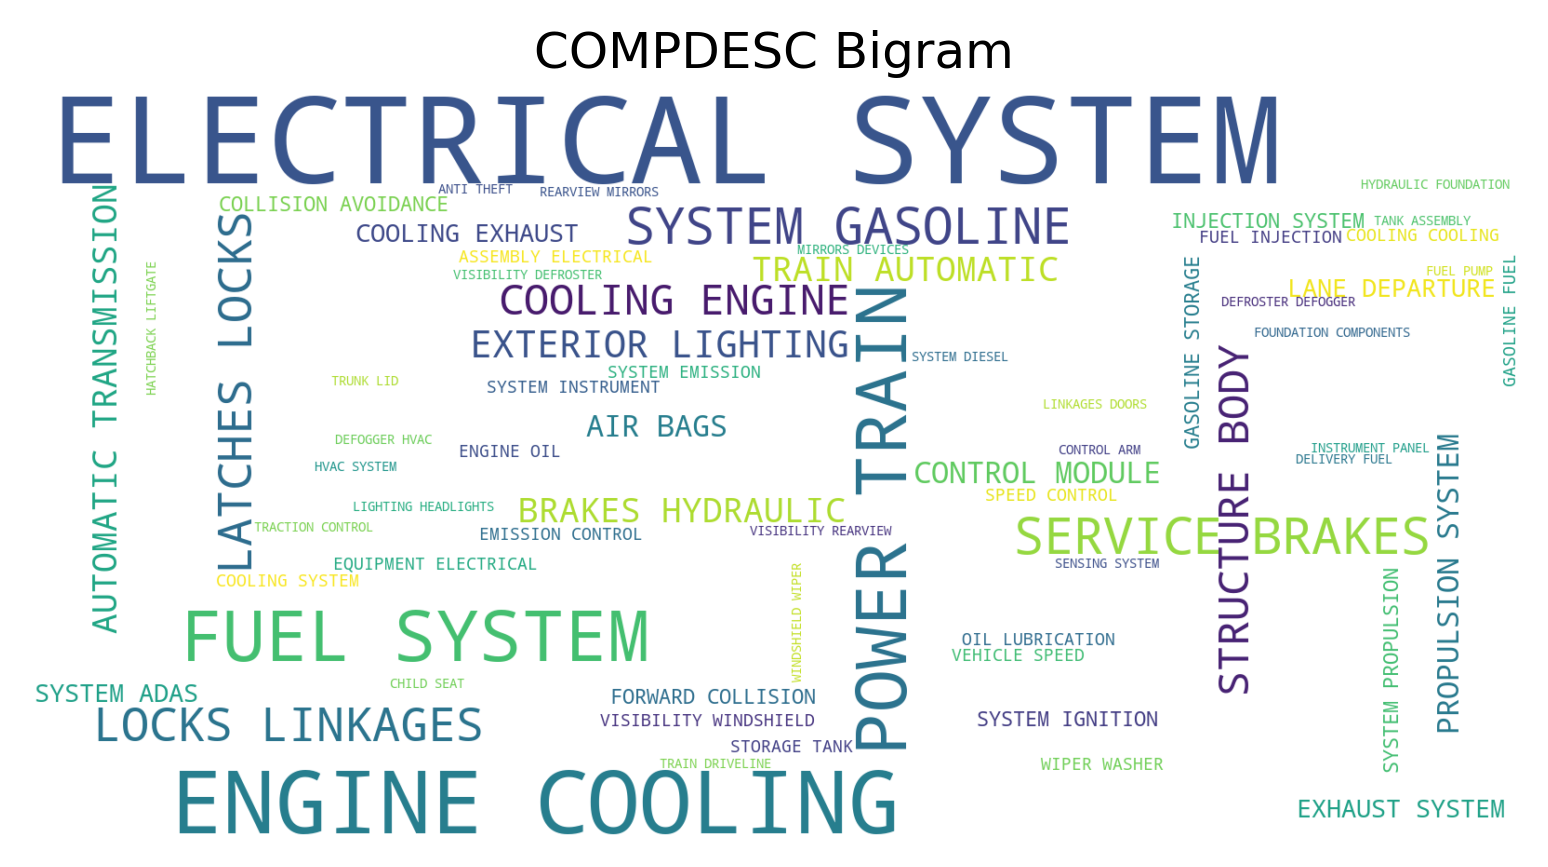

In [35]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPDESC Bigram')

# Data Quality Check

More in-depth analysis done on 2020-2024 dataset

In [71]:
find_columns_defining_uniqueness(df_complaints, duplicates_allowed=0)

['ODINO', 'COMPDESC', 'VEHICLES_TOWED_YN']

In [74]:
dup_odino_compdesc = df_complaints.loc[
    df_complaints.duplicated(subset=["ODINO", "COMPDESC"], keep=False)
]

In [75]:
dup_odino_compdesc.groupby("ODINO").nunique().sum(axis=0).sort_values(ascending=False)

VEHICLES_TOWED_YN    215
ORIG_OWNER_YN        215
CRUISE_CONT_YN       215
PROD_TYPE            215
ANTI_BRAKES_YN       215
YEARTXT              214
MMYTXT               214
MODELTXT             214
MAKETXT              212
MFR_NAME             212
VIN                  209
ORIG_EQUIP_YN        157
REPAIRED_YN          143
LOC_OF_TIRE          129
SEAT_TYPE            129
RESTRAINT_TYPE       127
DOT                  126
TIRE_FAIL_TYPE       111
COMPDESC             110
LDATE                108
CDESCR               108
CITY                 108
FIRE                 108
INJURED              108
FAILDATE             108
CRASH                108
DATEA                108
STATE                108
DEATHS               108
CMPL_TYPE            108
FUEL_TYPE            108
POLICE_RPT_YN        108
DEALER_CITY          108
DEALER_ZIP           108
DEALER_NAME          108
DEALER_TEL           108
MEDICAL_ATTN         108
DEALER_STATE         108
VEH_SPEED             37
PURCH_DT              26
